<a href="https://colab.research.google.com/github/LysanetsAndriy/Building-damage-segmentation/blob/main/HackDisaster_DINOv2_6_classes_no_test_640to518_comb_loss_emb_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! mkdir /content/drive/MyDrive/CVAT/data

In [ ]:
# ! unzip /content/drive/MyDrive/CVAT/Dataset_CVAT.zip -d /content/drive/MyDrive/CVAT/data

# Import libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import multiprocessing
from tqdm import tqdm
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import torchvision.transforms as T
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import models
from torchsummary import summary
from torch.amp import autocast, GradScaler
import timm
from timm import create_model
from sklearn.model_selection import train_test_split
from albumentations import Compose, RandomResizedCrop, HorizontalFlip, VerticalFlip, PiecewiseAffine, GaussianBlur, HueSaturationValue, RandomRotate90, GridDistortion, ShiftScaleRotate, RandomBrightnessContrast, GaussNoise, ElasticTransform, Perspective, OpticalDistortion
from albumentations.pytorch import ToTensorV2
from torchvision.transforms.functional import InterpolationMode
from skimage.segmentation import felzenszwalb
import shutil

# Config

In [ ]:
cpu_count_os = os.cpu_count()
print(f"Number of CPUs available (os.cpu_count): {cpu_count_os}")

max_workers = cpu_count_os
print(f"Suggested max_workers for DataLoader: {max_workers}")


Number of CPUs available (os.cpu_count): 2
Suggested max_workers for DataLoader: 2


In [ ]:
class Config:
  #path
  data_dir = '/content/drive/MyDrive/CVAT/data'
  image_dir = os.path.join(data_dir, 'images', 'default')
  annotations_file = os.path.join(data_dir, 'annotations.xml')
  logdir = 'logdir'

  patched_dataset_dir = '/content/patch_dataset_convnext_640_160_classes_6_emb_zipped'
  patched_dataset_dir_train = os.path.join(patched_dataset_dir, "train")
  patched_dataset_dir_val = os.path.join(patched_dataset_dir, "val")
  patched_dataset_dir_test = os.path.join(patched_dataset_dir, "test")

  gdrive_archive_path = '/content/drive/MyDrive/CVAT/patch_dataset_convnext_640_160_classes_6_emb_zipped.zip'
  gdrive_archive_path_train = os.path.join(patched_dataset_dir, "train")
  gdrive_archive_path_val = os.path.join(patched_dataset_dir, "val")
  gdrive_archive_path_test = os.path.join(patched_dataset_dir, "test")

  #model
  num_epochs = 20
  train_batch = 4
  seed = 1212
  num_workers = max_workers
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  pin_memory = True  # Speed up transfer to GPU

  #dataset
  patch_size=(518, 518)
  stride=160
  train_size=0.85
  val_size=0.15
  test_size=0.0


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(Config.seed)

# Datset Parsing

In [ ]:
def parse_annotations(xml_file):
    """
    Parse the annotations XML file to extract unique labels, polygon, and box data.

    Args:
        xml_file (str): Path to the annotations XML file.

    Returns:
        tuple: A dictionary mapping each unique label to an integer,
               and a list of dictionaries containing image metadata and polygon/box data.
    """
    # Parse XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    unique_labels = set()
    annotations = []

    # Iterate through each image and collect labels, polygons, and boxes
    for image in root.findall('image'):
        image_data = {
            'image_name': image.get('name'),
            'width': int(image.get('width')),
            'height': int(image.get('height')),
            'polygons': [],
            'boxes': []
        }

        # Collect polygons
        for polygon in image.findall('polygon'):
            label = polygon.get('label')
            if label:
                unique_labels.add(label)
                points = polygon.get('points')
                polygon_data = {
                    'label': label,
                    'points': points
                }
                image_data['polygons'].append(polygon_data)

        # Collect boxes
        for box in image.findall('box'):
            label = box.get('label')
            if label:
                unique_labels.add(label)
                xtl, ytl, xbr, ybr = map(float, [box.get('xtl'), box.get('ytl'), box.get('xbr'), box.get('ybr')])
                box_data = {
                    'label': label,
                    'xtl': xtl,
                    'ytl': ytl,
                    'xbr': xbr,
                    'ybr': ybr
                }
                image_data['boxes'].append(box_data)

        if image_data['polygons'] or image_data['boxes']:
            annotations.append(image_data)

    label_mapping = {
        'Other': 0,
        'Building': 1,
        'Roof': 2,
        'Damage': 3,
        'Broken Window': 4,
        'Damaged roof': 5,
    }

    # label_mapping = {label: idx + 1 for idx, label in enumerate(sorted(unique_labels))}
    return label_mapping, annotations


In [ ]:
label_mapping, annotations = parse_annotations(Config.annotations_file)

In [ ]:
print("Label Mapping:")
print(label_mapping)
print("\nSample Annotations:")
print(annotations[:2])

In [ ]:
def transform_boxes_to_polygons(annotations):
    """
    Transform bounding box annotations into a polygon-like format and add them to the dataset.

    Args:
        annotations (list): List of image annotations, each containing 'polygons' and 'boxes'.

    Returns:
        list: Updated annotations with boxes transformed into polygons.
    """
    updated_annotations = []

    for image_data in annotations:
        # Create a deep copy of image data to avoid modifying the original
        new_image_data = {
            'image_name': image_data['image_name'],
            'width': image_data['width'],
            'height': image_data['height'],
            'polygons': image_data['polygons'][:]
        }

        # Convert each box to polygon format and add to 'polygons' list
        for box in image_data.get('boxes', []):
            label = box['label']
            xtl, ytl, xbr, ybr = box['xtl'], box['ytl'], box['xbr'], box['ybr']

            # Define the four corners of the box
            box_points = f"{xtl},{ytl};{xbr},{ytl};{xbr},{ybr};{xtl},{ybr}"

            # Create a new polygon data dictionary
            box_as_polygon = {
                'label': label,
                'points': box_points
            }

            # Append the converted box (now as a polygon) to the polygons list
            new_image_data['polygons'].append(box_as_polygon)

        # Append the updated image data to the list
        updated_annotations.append(new_image_data)

    return updated_annotations


In [ ]:
# Apply the transformation to the annotations
annotations_with_polygons = transform_boxes_to_polygons(annotations)

print("Sample of transformed annotations with boxes as polygons:")
print(annotations_with_polygons[:2])
annotations = annotations_with_polygons

In [ ]:
# Split the dataset into train, val and test sets
train_annotations, val_annotations = train_test_split(
    annotations,
    test_size=Config.val_size,
    random_state=Config.seed
    )

# Data visualization

In [ ]:
color_mapping = {
    0: (211, 211, 211, 150),  # Light grey for 'Other', semi-transparent
    1: (0, 255, 0, 64),       # Green for 'Building', semi-transparent
    2: (255, 165, 0, 128),     # Orange for 'Roof', semi-transparent
    3: (255, 0, 255, 64),     # Purple for 'Damage', semi-transparent
    4: (0, 0, 255, 64),       # Blue for 'Broken Window', semi-transparent
    5: (255, 0, 0, 128),       # Red Blue for 'Damaged roof', semi-transparent
}

In [ ]:
def load_image(image_path):
    """
    Load an image from the specified path and return it as a PIL image.

    Args:
        image_path (str): Path to the image file.

    Returns:
        PIL.Image: Loaded image.
    """
    return Image.open(image_path).convert("RGB")

In [ ]:
def create_mask(image_data, label_mapping, width, height):
    """
    Create a binary mask for a single image based on the polygon annotations.

    Args:
        image_data (dict): Annotation data for a single image, containing polygon coordinates.
        label_mapping (dict): Mapping of labels to integer values for mask encoding.
        width (int): Width of the mask (same as image width).
        height (int): Height of the mask (same as image height).

    Returns:
        numpy.array: Mask with polygons drawn for segmentation.
    """
    priority_order = {
        'Other': 0,
        'Building': 1,
        'Roof': 2,
        'Damage': 3,
        'Broken Window': 4,
        'Damaged roof': 5,
    }

    # Sort polygons by priority (lower priority values are drawn first)
    sorted_polygons = sorted(image_data['polygons'], key=lambda p: priority_order.get(p['label']))

    mask = Image.new("RGBA", (width, height), (211, 211, 211, 150))  # Create an empty mask

    labels = []

    for polygon in sorted_polygons:
        label = polygon['label']
        points = polygon['points']
        points = [tuple(map(float, p.split(','))) for p in points.split(';')]

        labels.append(label)

        color = color_mapping[label_mapping[label]]

        # Draw polygon on the mask
        draw = ImageDraw.Draw(mask, "RGBA")
        draw.polygon(points, fill=color)
    print(labels)
    return np.array(mask)

In [ ]:
def visualize_samples(annotations, label_mapping, num_samples=1):
    """
    Visualize a few samples from the dataset with their annotations overlayed.

    Args:
        annotations (list): List of image annotations.
        label_mapping (dict): Dictionary mapping labels to integers.
        num_samples (int): Number of samples to visualize.
    """
    plt.figure(figsize=(15, num_samples * 5))

    for i, image_data in enumerate(random.sample(annotations, num_samples)):
        image_path = os.path.join(Config.image_dir, image_data['image_name'])
        image = load_image(image_path)
        mask = create_mask(image_data, label_mapping, image.width, image.height)

        plt.subplot(num_samples, 1, i+1)
        plt.imshow(image)
        # plt.title(f"Original Image: {image_data['image_name']}")
        plt.imshow(mask, alpha=0.7)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
print(annotations[6])

['Other', 'Other', 'Building', 'Damage', 'Damage', 'Damage', 'Damage', 'Damage', 'Damage', 'Broken Window', 'Broken Window', 'Broken Window', 'Broken Window', 'Broken Window', 'Broken Window', 'Broken Window', 'Broken Window', 'Broken Window', 'Broken Window']


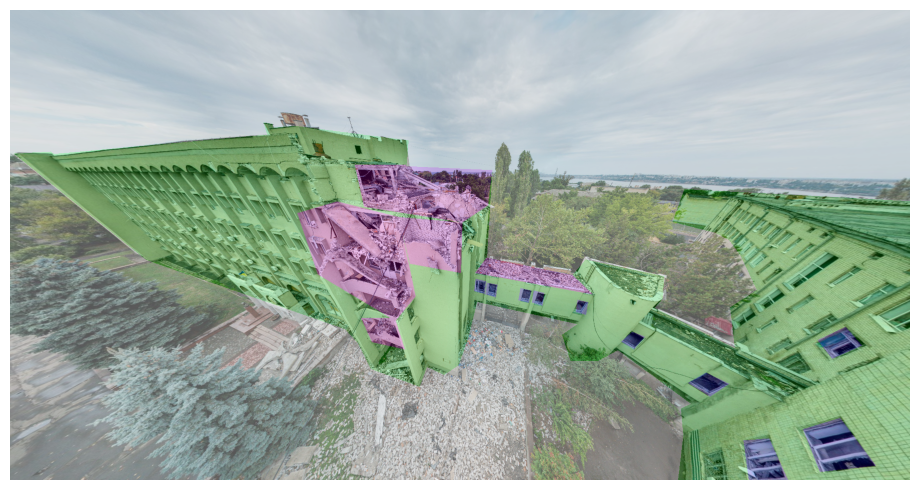

In [ ]:
visualize_samples(annotations, label_mapping, num_samples=1)

Building: **Green**, Damage: **Purple**, Other: **Grey**



---



# Create label mask

In [ ]:
def create_label_mask(image_data, label_mapping, width, height):
    """
    Create an integer label mask for a single image, where each pixel's value
    corresponds to the class ID.

    Args:
        image_data (dict): Annotation data for a single image, containing polygon coordinates.
        label_mapping (dict): Mapping of labels to integer values.
        width (int): Width of the mask (same as image width).
        height (int): Height of the mask (same as image height).

    Returns:
        numpy.array: Integer mask where each pixel contains the class ID (1 to 4).
    """
    # Priority order for rendering polygons (lower priority values are drawn first)
    priority_order = {
        'Other': 0,
        'Building': 1,
        'Roof': 2,
        'Damage': 3,
        'Broken Window': 4,
        'Damaged roof': 5,
    }


    # Sort polygons by priority
    sorted_polygons = sorted(image_data['polygons'], key=lambda p: priority_order.get(p['label'], 0))

    # Initialize mask with zeros ('Other')
    mask = np.zeros((height, width), dtype=np.int32)

    for polygon in sorted_polygons:
        label = polygon['label']
        points = polygon['points']
        points = [tuple(map(float, p.split(','))) for p in points.split(';')]

        # Get the class ID for the label
        class_id = label_mapping[label]

        # Draw polygon with the corresponding class ID
        pil_mask = Image.fromarray(mask)
        draw = ImageDraw.Draw(pil_mask)
        draw.polygon(points, fill=class_id)
        mask = np.array(pil_mask)  # Update mask

    return mask

In [ ]:
def apply_color_mapping(mask, color_mapping):
    """
    Apply color mapping to the integer mask.

    Args:
        mask (numpy.array): Integer mask where each pixel contains the class ID.
        color_mapping (dict): Dictionary mapping class IDs to RGBA color tuples.

    Returns:
        numpy.array: RGBA image representing the color-mapped mask.
    """
    h, w = mask.shape
    mask_colored = np.zeros((h, w, 4), dtype=np.uint8)  # Initialize RGBA image
    for class_id, color in color_mapping.items():
        mask_colored[mask == class_id] = color  # Assign RGBA color to class ID pixels
    return mask_colored

In [ ]:
def visualize_label_masks(samples, label_mapping, image_dir, mask_height, mask_width, color_mapping):
    """
    Visualize label masks for a set of sample data examples with color mapping.

    Args:
        samples (list): A list of sample annotations to visualize (e.g., `annotations[:5]`).
        label_mapping (dict): Dictionary mapping labels to integer IDs.
        image_dir (str): Directory containing the images.
        mask_height (int): Height of the mask (should match the image height).
        mask_width (int): Width of the mask (should match the image width).
        color_mapping (dict): Dictionary mapping class IDs to RGBA colors.
    """
    plt.figure(figsize=(15, len(samples) * 5))
    for idx, sample in enumerate(samples):
        # Load image
        image_path = os.path.join(image_dir, sample['image_name'])
        image = Image.open(image_path).convert("RGB")

        # Generate label mask for the sample
        mask = create_label_mask(sample, label_mapping, mask_width, mask_height)

        # Apply color mapping to the mask
        mask_colored = apply_color_mapping(mask, color_mapping)

        # Plot image and mask
        plt.subplot(len(samples), 2, idx * 2 + 1)
        plt.imshow(image)
        plt.title(f"Original Image: {sample['image_name']}")
        plt.axis('off')

        plt.subplot(len(samples), 2, idx * 2 + 2)
        plt.imshow(mask_colored)
        plt.title("Label Mask with Color Mapping")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

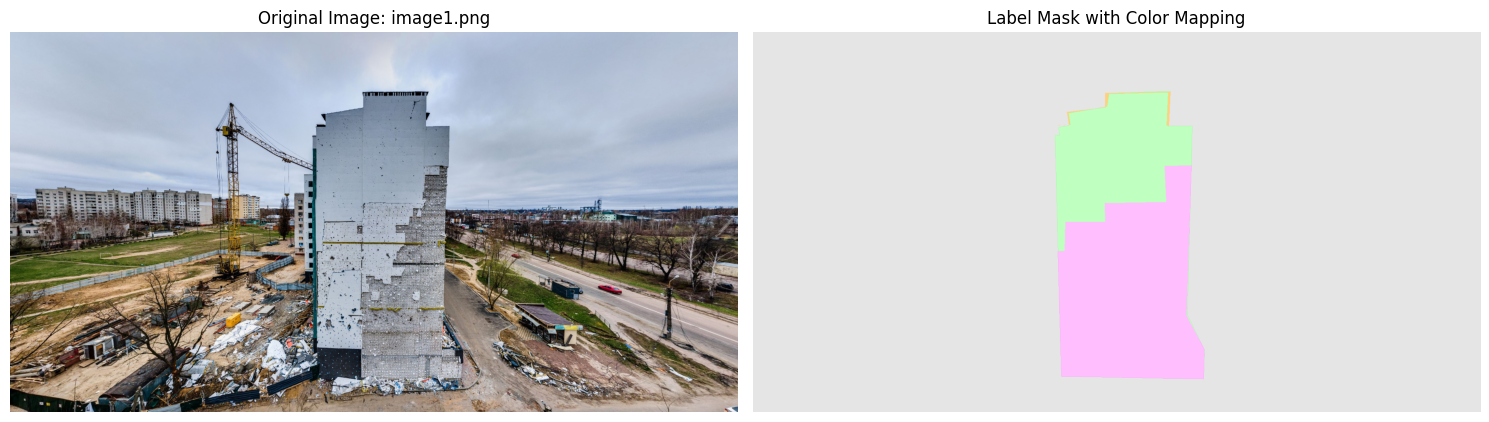

In [ ]:
# Select some samples for visualization
sample_annotations = annotations[0:1]  # Change this to display more or fewer examples

# Assume all images have the same width and height; otherwise, you’ll need to handle each size.
sample_width = sample_annotations[0]['width']
sample_height = sample_annotations[0]['height']

color_mapping = {
    0: (211, 211, 211, 150),  # Light grey for 'Other', semi-transparent
    1: (0, 255, 0, 64),       # Green for 'Building', semi-transparent
    2: (255, 165, 0, 128),     # Orange for 'Roof', semi-transparent
    3: (255, 0, 255, 64),     # Purple for 'Damage', semi-transparent
    4: (0, 0, 255, 64),       # Blue for 'Broken Window', semi-transparent
    5: (255, 0, 0, 128),       # Red Blue for 'Damaged roof', semi-transparent
}

# Visualize label masks
visualize_label_masks(sample_annotations, label_mapping, Config.image_dir,
                      sample_height, sample_width, color_mapping=color_mapping)


{'Other': 0,'Building': 1,'Roof': 2,'Damage': 3,'Broken Window': 4,'Damaged roof': 5}

# Create Patch dataset

In [ ]:
def save_patched_dataset_with_embedding(annotations, image_dir, label_mapping,
                                          output_dir, model, transform,
                                          patch_size=(224, 224), stride=112,
                                          device=Config.device):
    """
    Save image and mask patches as separate files in a specified folder,
    using dynamic stride (no padding) so that patches are uniformly distributed
    over a resized full image.

    If the original image is smaller than patch_size, it is resized (with bilinear
    interpolation for images and nearest for masks). Otherwise, the image is left at
    its original size. Then, the image is resized (if needed) so that its width and height
    are used to compute a dynamic stride that evenly covers the image with patches of
    fixed patch_size.

    Args:
        annotations (list): Parsed annotations containing polygon data.
        image_dir (str): Directory containing the original images.
        label_mapping (dict): Mapping of label names to integers.
        output_dir (str): Directory where patches will be stored.
        model (nn.Module): Pre-trained model to generate full image embeddings.
        transform (callable): Transformation function for images before embedding generation.
        patch_size (tuple): Patch size (width, height).
        stride (int): Nominal stride for sliding window.
        device (str): Device to perform computation on (e.g., 'cuda' or 'cpu').

    Returns:
        None
    """
    os.makedirs(output_dir, exist_ok=True)
    patch_index = 0

    # Define transforms for full-image embedding and for patches
    full_image_transform = T.Compose([
        T.Resize((384, 384), interpolation=InterpolationMode.BILINEAR),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
    ])
    patch_transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
    ])

    model.eval()
    with torch.no_grad():
        for sample in tqdm(annotations, desc="Processing Images"):
            # Load image and create mask
            image_path = os.path.join(image_dir, sample['image_name'])
            image = Image.open(image_path).convert("RGB")
            width, height = image.size
            mask = create_label_mask(sample, label_mapping, width, height)

            # If image is too small, resize it so that both dimensions >= patch_size
            if width < patch_size[0] or height < patch_size[1]:
                scale_factor = max(patch_size[0] / width, patch_size[1] / height)
                new_width = int(round(width * scale_factor))
                new_height = int(round(height * scale_factor))
                # Use bilinear for image, nearest for mask
                resize_img = T.Resize((new_height, new_width), interpolation=InterpolationMode.BILINEAR)
                resize_mask = T.Resize((new_height, new_width), interpolation=InterpolationMode.NEAREST)
                image = resize_img(image)
                mask = resize_mask(Image.fromarray(mask.astype(np.uint8)))
            else:
                new_width, new_height = width, height

            image_resized = image
            mask_resized = mask

            # Convert the full image and mask to numpy arrays
            image_np = np.array(image_resized)
            mask_np = np.array(mask_resized)

            # Compute dynamic stride along width and height:
            p_w, p_h = patch_size  # desired patch width and height

            # Number of patches along width:
            if new_width == p_w:
                n_w = 1
                dyn_stride_w = 0
            else:
                n_w = max(2, int(round((new_width - p_w) / stride)) + 1)
                dyn_stride_w = (new_width - p_w) / (n_w - 1)

            # Similarly, number of patches along height:
            if new_height == p_h:
                n_h = 1
                dyn_stride_h = 0
            else:
                n_h = max(2, int(round((new_height - p_h) / stride)) + 1)
                dyn_stride_h = (new_height - p_h) / (n_h - 1)

            # Compute full image embedding using full_image_transform
            image_tensor = full_image_transform(image_resized).unsqueeze(0).to(device)
            full_image_embedding = model(image_tensor)
            full_image_embedding = full_image_embedding.squeeze(0).cpu().numpy()  # shape e.g. [1024]

            # Slide over the image using the computed dynamic stride
            for i in range(n_h):
                y = int(round(i * dyn_stride_h))
                # Ensure patch stays within bounds
                if y + p_h > new_height:
                    y = new_height - p_h
                for j in range(n_w):
                    x = int(round(j * dyn_stride_w))
                    if x + p_w > new_width:
                        x = new_width - p_w

                    # Extract the patch from image and mask
                    image_patch = image_resized.crop((x, y, x + p_w, y + p_h))
                    mask_patch = Image.fromarray(mask_np.astype(np.uint8)).crop((x, y, x + p_w, y + p_h))
                    mask_patch = np.array(mask_patch)
                    # Compute normalized positional embedding for the patch
                    pos_x = x / new_width
                    pos_y = y / new_height
                    positional_embedding = np.array([pos_x, pos_y], dtype=np.float32)

                    # Save patch along with full image embedding and positional embedding
                    patch_path = os.path.join(output_dir, f"patch_{patch_index}.npz")
                    np.savez_compressed(
                        patch_path,
                        image=np.array(image_patch),
                        mask=np.array(mask_patch),
                        embedding=full_image_embedding,
                        position=positional_embedding
                    )
                    patch_index += 1

    print(f"Patched dataset with embeddings saved as npz files to: {output_dir}")


In [ ]:
output_dir = "/content/drive/MyDrive/CVAT/patch_dataset_convnext_640_160_classes_6_emb_zipped"
output_train_dir = os.path.join(output_dir, "train")
output_val_dir = os.path.join(output_dir, "val")
output_test_dir = os.path.join(output_dir, "test")

# convnext_model = create_model(
#     'convnext_large_mlp.clip_laion2b_augreg_ft_in12k_384',
#     pretrained=True,
#     num_classes=0
# )
# convnext_model.to(Config.device)

# full_image_transform = transforms.Compose([
#     transforms.Resize((384, 384)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])



In [ ]:
# print("Processing training set...")
# save_patched_dataset_with_embedding(
#     annotations=train_annotations,
#     image_dir=Config.image_dir,
#     label_mapping=label_mapping,
#     output_dir=output_train_dir,
#     model=convnext_model,
#     transform=full_image_transform,
#     patch_size=Config.patch_size,
#     stride=Config.stride,
#     device=Config.device
# )


Processing training set...


Processing Images: 100%|██████████| 246/246 [08:50<00:00,  2.16s/it]

Patched dataset with embeddings saved as npz files to: /content/drive/MyDrive/CVAT/patch_dataset_convnext_224_180_classes_6_emb_zipped/train


In [ ]:
# print("Processing validation set...")
# save_patched_dataset_with_embedding(
#     annotations=val_annotations,
#     image_dir=Config.image_dir,
#     label_mapping=label_mapping,
#     output_dir=output_val_dir,
#     model=convnext_model,
#     transform=full_image_transform,
#     patch_size=Config.patch_size,
#     stride=Config.stride,
#     device=Config.device
# )


Processing validation set...


Processing Images: 100%|██████████| 44/44 [01:28<00:00,  2.02s/it]

Patched dataset with embeddings saved as npz files to: /content/drive/MyDrive/CVAT/patch_dataset_convnext_224_180_classes_6_emb_zipped/val


In [ ]:
folder_to_zip = '/content/drive/MyDrive/CVAT/patch_dataset_convnext_640_160_classes_6_emb_zipped'
output_zip = '/content/drive/MyDrive/CVAT/patch_dataset_convnext_640_160_classes_6_emb_zipped.zip'

# # Create the zip file
# shutil.make_archive(
#     base_name=output_zip.replace('.zip', ''),  # Remove '.zip' extension for shutil
#     format='zip',  # Compression format
#     root_dir=folder_to_zip  # Folder to zip
# )

# print(f"Dataset zipped successfully at: {output_zip}")


Dataset zipped successfully at: /content/drive/MyDrive/CVAT/patch_dataset_convnext_224_180_classes_6_emb_zipped.zip


In [ ]:
if os.path.exists(output_zip):
    print(f"Archive created: {output_zip}")
else:
    print("Error: Archive creation failed!")


Archive created: /content/drive/MyDrive/CVAT/patch_dataset_convnext_224_180_classes_6_emb_zipped.zip


In [ ]:
# Destination path in the Colab environment
colab_archive_path = '/content/patch_dataset_convnext_640_160_classes_6_emb_zipped.zip'

# Copy the file to Colab
shutil.copy(Config.gdrive_archive_path, colab_archive_path)

print(f"Archive copied to Colab: {colab_archive_path}")

Archive copied to Colab: /content/patch_dataset_convnext_224_180_classes_6_emb_zipped.zip


In [ ]:
unzip_folder = '/content/patch_dataset_convnext_640_160_classes_6_emb_zipped'

# Unzip the archive
shutil.unpack_archive(colab_archive_path, unzip_folder, 'zip')

print(f"Archive unzipped to: {unzip_folder}")

Archive unzipped to: /content/patch_dataset_convnext_224_180_classes_6_emb_zipped


# DataSet

In [ ]:
class PatchedDataset(Dataset):
    """
        Dataset class for patches with full-image embeddings and positional embeddings.

        Args:
            patch_dir (str): Directory containing patch files in `.npz` format.
            transform (callable, optional): Transformation function for images. Default is None.
    """
    def __init__(self, patch_dir, transform=None):
        self.patch_files = sorted(os.listdir(patch_dir))
        self.patch_dir = patch_dir
        self.transform = transform
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

    def __len__(self):
        return len(self.patch_files)

    def __getitem__(self, idx):
        patch_path = os.path.join(self.patch_dir, self.patch_files[idx])

        patch = np.load(patch_path)

        image_np = patch['image']   # H×W×3, dtype uint8
        mask_np  = patch['mask']    # H×W, dtype int

        image_pil = Image.fromarray(image_np)
        mask_pil  = Image.fromarray(mask_np.astype(np.uint8))

        image_resized_pil = image_pil.resize((518, 518), Image.BILINEAR)
        mask_resized_pil  = mask_pil.resize((518, 518), Image.NEAREST)

        image = np.array(image_resized_pil)
        mask  = np.array(mask_resized_pil)

        embedding = torch.tensor(patch['embedding'], dtype=torch.float32)
        position = torch.tensor(patch['position'], dtype=torch.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            image = transforms.ToTensor()(image)
            image = transforms.Normalize(mean=self.mean, std=self.std)(image)
            mask = augmented['mask']
        else:
            # Convert image to tensor and apply normalization
            image = transforms.ToTensor()(image)
            image = transforms.Normalize(mean=self.mean, std=self.std)(image)

        mask = torch.tensor(mask, dtype=torch.long)
        return image, mask, embedding, position

In [ ]:
train_transform = Compose([
    RandomResizedCrop(size=Config.patch_size, scale=(0.6, 0.8), ratio=(1.0, 1.0), p=1.0),
    # GridDistortion(num_steps=10, distort_limit=0.5, p=0.3),
    HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    # GaussianBlur(blur_limit=(3, 7), p=0.3),
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.4),
    GaussNoise(std_range=(0.1, 0.2), p=0.4),
    ElasticTransform(alpha=20, sigma=60, p=0.4),
])

In [ ]:
train_dataset = PatchedDataset(
    patch_dir=Config.patched_dataset_dir_train,
    transform=train_transform
)
val_dataset = PatchedDataset(
    patch_dir=Config.patched_dataset_dir_val
)

In [ ]:
def display_patched_dataset_item(patched_dataset, idx, color_mapping):
    """
    Display an image and its corresponding mask with color mapping from the patched dataset.

    Args:
        patched_dataset (Dataset): Instance of the patched dataset.
        idx (int): Index of the item to display.
        color_mapping (dict): Dictionary mapping class indices to RGBA colors.

    Returns:
        None
    """
    # Get the image and mask
    image, mask, embedding, position = patched_dataset[idx]  # image: tensor, mask: tensor
    print(f"Image Shape: {image.shape}, Mask Shape: {mask.shape}")
    print(f"Embedding Shape: {embedding.shape}")
    print(f"Positional Embedding: {position}")

    # Convert image tensor to NumPy array for visualization
    std = np.array([0.229, 0.224, 0.225])
    mean = np.array([0.485, 0.456, 0.406])

    image_np = image.permute(1, 2, 0).numpy()  # Convert [C, H, W] -> [H, W, C]
    image_np = image_np * std + mean  # Reverse normalization
    image_np = np.clip(image_np, 0, 1)  # Ensure pixel values are in range [0, 1]

    # Convert mask tensor to NumPy array
    mask_np = mask.numpy()

    # Apply color mapping to the mask
    h, w = mask_np.shape
    mask_colored = np.full((h, w, 4), color_mapping[0], dtype=np.uint8) # Initialize RGBA image
    for class_idx, color in color_mapping.items():
        mask_colored[mask_np == class_idx] = color  # Assign color to corresponding class indices

    # Plot the image and colored mask side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(image_np)
    axes[0].set_title("Image")
    axes[0].axis("off")

    axes[1].imshow(mask_colored)
    axes[1].set_title("Mask with Color Mapping")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
color_mapping = {
    0: (211, 211, 211, 150),  # Light grey for 'Other', semi-transparent
    1: (0, 255, 0, 64),       # Green for 'Building', semi-transparent
    2: (255, 165, 0, 128),     # Orange for 'Roof', semi-transparent
    3: (255, 0, 255, 64),     # Purple for 'Damage', semi-transparent
    4: (0, 0, 255, 64),       # Blue for 'Broken Window', semi-transparent
    5: (255, 0, 0, 128),       # Red Blue for 'Damaged roof', semi-transparent
}

for i in range(10):
  id = np.random.randint(len(train_dataset))
  display_patched_dataset_item(train_dataset, idx=id, color_mapping=color_mapping)

for i in range(10):
  id = np.random.randint(len(val_dataset))
  display_patched_dataset_item(val_dataset, idx=id, color_mapping=color_mapping)

# for i in range(1):
#   id = np.random.randint(len(test_dataset))
#   display_patched_dataset_item(test_dataset, idx=id, color_mapping=color_mapping)

# DataLoader

In [ ]:
train_fraction = 1.0
train_length = int(len(train_dataset) * train_fraction)
unused_length = len(train_dataset) - train_length

# Split the train_dataset into a used subset and an unused subset
train_dataset_used, _ = random_split(train_dataset, [train_length, unused_length])

# Create DataLoaders for the reduced training set, validation set, and test set
train_dataloader = DataLoader(
    train_dataset_used,
    batch_size=Config.train_batch,  # Batch size for training
    shuffle=True,                   # Shuffle training data
    num_workers=Config.num_workers,
    pin_memory=Config.pin_memory                 # Speed up transfer to GPU if available
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=Config.train_batch,  # Batch size for validation
    shuffle=False,
    num_workers=Config.num_workers,
    pin_memory=Config.pin_memory
)

# Calculate total dataset size for verification
total_length = len(train_dataset_used) + len(val_dataset)

# Example output to verify the splits
print(f"Total dataset size: {total_length}")
print(f"Train set size (used): {len(train_dataset_used)}")
print(f"Validation set size: {len(val_dataset)}")


Total dataset size: 12943
Train set size (used): 11042
Validation set size: 1901


# DINOv2-UNet model
UNet model with DINOv2 as backbone

In [ ]:
class UNetDinoV2(nn.Module):
    """
    U-Net that uses DINOv2 (ViT) as a self‐supervised encoder backbone.
    """
    def __init__(self, num_classes, dino_model="vit_large_patch14_reg4_dinov2.lvd142m"):
        super().__init__()
        self.num_classes = num_classes

        # 1) Load DINOv2 with feature‐extraction mode
        #    We choose out_indices at 4 depths.
        self.encoder = timm.create_model(
            dino_model,
            pretrained=True,
            features_only=True,
            out_indices=(1, 7, 12, 20),
        )
        encoder_channels = self.encoder.feature_info.channels()
        print(encoder_channels)
        c1, c2, c3, c4 = encoder_channels  # e.g. [192, 384, 768, 768]

        # 2) Embedding layers for concatenation at bottleneck
        #    Last DINOv2 layer has c4 channels
        self.image_emb_fc    = nn.Linear(1536, c4 // 2)
        self.position_emb_fc = nn.Linear(2,   c4 // 4)

        # 3) Build U‐Net decoder blocks
        self.bottleneck = self._conv_block(c4 + (c4 // 2) + (c4 // 4), c3)
        self.decoder4   = self._conv_block(c3 + c3, c2)
        self.decoder3   = self._conv_block(c2 + c2, c1)
        self.decoder2   = self._conv_block(c1 + c1, c1 // 2)
        self.decoder1   = self._conv_block(c1 // 2, c1 // 4)
        self.conv_last  = nn.Conv2d(c1 // 4, num_classes, kernel_size=1)

    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch // 2),
            nn.GELU(),
            nn.Dropout(0.6),
            nn.Conv2d(out_ch // 2, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.GELU(),
            nn.Dropout(0.6),
        )

    def forward(self, x, image_embedding, position_embedding):
        """
        Args:
            x (torch.Tensor): [B, 3, H, W] input image (normalized to [0,1])
            image_embedding (torch.Tensor): [B, 768] global DINO embedding (optional)
            position_embedding (torch.Tensor): [B, 2] normalized (x/w, y/h)
        Returns:
            seg_map [B, num_classes, H, W]
        """
        # 1) Pass through DINOv2 encoder to get four feature maps
        feats = self.encoder(x)
        enc1, enc2, enc3, enc4 = feats  # shapes:
        #   enc1 [B, c1, H/patch1, W/patch1]
        #   enc2 [B, c2, H/patch2, W/patch2]
        #   enc3 [B, c3, H/patch3, W/patch3]
        #   enc4 [B, c4, H/patch4, W/patch4]

        # 2) Inject embeddings into enc4
        B, _, H4, W4 = enc4.shape
        img_e = self.image_emb_fc(image_embedding).view(B, -1, 1, 1).expand(-1, -1, H4, W4)
        pos_e = self.position_emb_fc(position_embedding).view(B, -1, 1, 1).expand(-1, -1, H4, W4)
        bott = torch.cat([enc4, img_e, pos_e], dim=1)
        bott = self.bottleneck(bott)

        # 3) Decoder Stage 4
        d4 = F.interpolate(bott, size=enc3.shape[2:], mode='bilinear', align_corners=False)
        d4 = self.decoder4(torch.cat([d4, enc3], dim=1))

        # 4) Decoder Stage 3
        d3 = F.interpolate(d4, size=enc2.shape[2:], mode='bilinear', align_corners=False)
        d3 = self.decoder3(torch.cat([d3, enc2], dim=1))

        # 5) Decoder Stage 2
        d2 = F.interpolate(d3, size=enc1.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.decoder2(torch.cat([d2, enc1], dim=1))

        # 6) Decoder Stage 1 → restore full resolution
        d1 = F.interpolate(d2, scale_factor=4, mode='bilinear', align_corners=False)
        d1 = self.decoder1(d1)
        out = F.interpolate(d1, scale_factor=3.5, mode='bilinear', align_corners=False)

        # 7) Final 1×1 conv to num_classes
        return self.conv_last(out)


In [ ]:
def custom_summary(model, x_shape, emb_shape, pos_shape, device=Config.device):
    """
    Print a summary of the model by performing a forward pass with dummy inputs.

    Args:
        model (nn.Module): The model to summarize.
        x_shape (tuple): Shape of the input image tensor (e.g., (batch_size, 3, 224, 224)).
        emb_shape (tuple): Shape of the image embedding tensor (e.g., (batch_size, 1024)).
        pos_shape (tuple): Shape of the positional embedding tensor (e.g., (batch_size, 2)).
        device (str): Device to run the dummy inputs on.
    """
    model.eval()

    x = torch.randn(*x_shape).to(device)
    image_emb = torch.randn(*emb_shape).to(device)
    pos_emb = torch.randn(*pos_shape).to(device)

    with torch.no_grad():
        output = model(x, image_emb, pos_emb)

    print(model)

    print(f"Output shape: {output.shape}")

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params}")

In [ ]:
batch_size = 1
x_shape = (batch_size, 3, 518, 518)
emb_shape = (batch_size, 1536)
pos_shape = (batch_size, 2)

num_classes = len(label_mapping)

model = UNetDinoV2(num_classes=num_classes).to(Config.device)

custom_summary(model, x_shape, emb_shape, pos_shape, device=Config.device)

In [ ]:
timm.list_models("*dinov2*", pretrained=True)

# Metrics

In [ ]:
def calculate_pixel_accuracy(pred, true):
  """
    Calculate pixel-wise accuracy.

    Args:
        pred (np.ndarray): Predicted mask of shape (H, W).
        true (np.ndarray): True mask of shape (H, W).

    Returns:
        float: Pixel-wise accuracy.
  """
  correct_pixels = np.sum(pred == true)
  total_pixels = true.size
  return correct_pixels / total_pixels

In [ ]:
def calculate_iou(pred, true, num_classes):
  """
  Calculate Intersection over Union (IoU) for all classes.

    Args:
        pred (np.ndarray): Predicted mask of shape (H, W).
        true (np.ndarray): True mask of shape (H, W).
        num_classes (int): Total number of classes.

    Returns:
        np.ndarray: IoU score for each class.
  """
  ious = []
  for cls in range(num_classes):
    intersection = np.logical_and(pred == cls, true == cls).sum()
    union = np.logical_or(pred == cls, true == cls).sum()
    if union == 0:
      ious.append(float('nan'))
    else:
      ious.append(intersection / union)
  return np.array(ious)

In [ ]:
def calculate_dice(pred, true, num_classes):
  """
    Calculate Dice Coefficient for all classes.

    Args:
        pred (np.ndarray): Predicted mask of shape (H, W).
        true (np.ndarray): True mask of shape (H, W).
        num_classes (int): Total number of classes.

    Returns:
        np.ndarray: Dice score for each class.
  """
  dice_scores = []
  for cls in range(num_classes):
    intersection = np.logical_and(pred == cls, true == cls).sum()
    pred_sum = (pred == cls).sum()
    true_sum = (true == cls).sum()
    if pred_sum + true_sum == 0:
      dice_scores.append(float('nan'))
    else:
      dice_scores.append(2 * intersection / (pred_sum + true_sum))
  return np.array(dice_scores)

# Focal Tversky Loss

In [ ]:
class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=1.33, epsilon=1e-10, class_weights=None):
        """
        Focal Tversky Loss with optional class weighting.

        Args:
            alpha (float): Controls penalty for false positives.
            beta (float): Controls penalty for false negatives.
            gamma (float): Focal parameter to focus on hard examples.
            epsilon (float): Small constant to avoid division by zero.
            class_weights (torch.Tensor or None): Tensor of shape [num_classes] with weights for each class.
        """
        super(FocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.epsilon = epsilon
        self.class_weights = class_weights

    def forward(self, output, target):
        """
        Compute the weighted Focal Tversky Loss.

        Args:
            output (torch.Tensor): Model predictions of shape [N, num_classes, H, W].
            target (torch.Tensor): Ground truth of shape [N, H, W].

        Returns:
            torch.Tensor: Weighted focal Tversky loss.
        """
        output = F.softmax(output, dim=1)  # Apply softmax to get probabilities
        num_classes = output.shape[1]

        # Ensure class weights are on the same device
        if self.class_weights is not None:
            self.class_weights = self.class_weights.to(output.device)
            assert self.class_weights.shape[0] == num_classes, \
                f"Mismatch: num_classes={num_classes}, class_weights.shape={self.class_weights.shape}"

        # Convert target to one-hot encoding
        target_one_hot = F.one_hot(target, num_classes=num_classes).permute(0, 3, 1, 2).float()

        # Compute TP, FP, FN
        TP = torch.sum(output * target_one_hot, dim=(2, 3))
        FP = torch.sum(output * (1 - target_one_hot), dim=(2, 3))
        FN = torch.sum((1 - output) * target_one_hot, dim=(2, 3))

        # Compute Tversky Index
        tversky_index = TP / (TP + self.alpha * FP + self.beta * FN + self.epsilon)

        # Compute Focal Tversky Loss
        loss = (1 - tversky_index) ** self.gamma

        # Apply class weights
        if self.class_weights is not None:
            loss = loss * self.class_weights.reshape((1, num_classes))

        return torch.mean(loss)


# Soft Dice Loss

In [ ]:
class SoftDiceLoss(nn.Module):
    def __init__(self, class_weights=None, reduction='mean', use_softmax=True):
        """
        Soft Dice Loss with optional class weighting.

        Args:
            class_weights (torch.Tensor or None): Tensor of shape [num_classes] with weights for each class.
            reduction (str): 'mean' or 'none'. Determines how to reduce the loss.
            use_softmax (bool): If True, apply softmax to the outputs.
        """
        super(SoftDiceLoss, self).__init__()
        self.use_softmax = use_softmax
        self.reduction = reduction
        self.class_weights = class_weights

    def forward(self, output, target, epsilon=1e-12):
        """
        Compute the weighted soft Dice loss.

        Args:
            output (torch.Tensor): Predicted output of shape [N, num_classes, H, W].
            target (torch.Tensor): Ground truth labels of shape [N, H, W].
            epsilon (float): Small constant to avoid division by zero.

        Returns:
            torch.Tensor: The weighted Dice loss value.
        """
        num_classes = output.shape[1]

        # Ensure class weights have the correct shape
        if self.class_weights is not None:
            self.class_weights = self.class_weights.to(output.device)
            assert self.class_weights.shape[0] == num_classes, \
                f"Mismatch: num_classes={num_classes}, class_weights.shape={self.class_weights.shape}"

        # Apply softmax if specified
        if self.use_softmax:
            output = F.softmax(output, dim=1)

        # Convert target to one-hot encoding
        one_hot_target = F.one_hot(target.to(torch.int64), num_classes=num_classes).permute(0, 3, 1, 2).to(torch.float)

        # Compute numerator and denominator for Dice loss
        numerator = 2.0 * torch.sum(output * one_hot_target, dim=(-2, -1))
        denominator = torch.sum(output + one_hot_target, dim=(-2, -1))

        # Compute Dice coefficient
        dice_coefficient = (numerator + epsilon) / (denominator + epsilon)
        dice_loss = 1.0 - dice_coefficient

        # Apply class weights correctly
        if self.class_weights is not None:
            dice_loss = dice_loss * self.class_weights.reshape((1, num_classes))

        if self.reduction == 'mean':
            return dice_loss.mean()
        elif self.reduction == 'none':
            return dice_loss
        else:
            raise ValueError(f"Invalid reduction mode: {self.reduction}")


# IoU loss

In [ ]:
class IoULoss(nn.Module):
    """
    Intersection over Union (IoU) Loss with class weighting.
    """
    def __init__(self, smooth=1e-8, class_weights=None):
        """
        Args:
            smooth (float): Smoothing factor to avoid division by zero.
            class_weights (torch.Tensor or None): Tensor of shape [num_classes] with weights for each class.
        """
        super(IoULoss, self).__init__()
        self.smooth = smooth
        self.class_weights = class_weights

    def forward(self, outputs, targets):
        """
        Compute the weighted IoU loss.

        Args:
            outputs (torch.Tensor): Predicted logits of shape [B, num_classes, H, W].
            targets (torch.Tensor): Ground truth labels of shape [B, H, W].

        Returns:
            torch.Tensor: Weighted IoU loss value.
        """
        num_classes = outputs.shape[1]

        # Ensure class weights have the correct shape
        if self.class_weights is not None:
            self.class_weights = self.class_weights.to(outputs.device)
            assert self.class_weights.shape[0] == num_classes, \
                f"Mismatch: num_classes={num_classes}, class_weights.shape={self.class_weights.shape}"

        # Apply softmax to predictions
        outputs = F.softmax(outputs, dim=1)

        # Convert target to one-hot encoding
        targets_one_hot = F.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2).float()

        # Compute intersection and union
        intersection = torch.sum(outputs * targets_one_hot, dim=(2, 3))
        union = torch.sum(outputs + targets_one_hot, dim=(2, 3)) - intersection

        # IoU score for each class
        iou = (intersection + self.smooth) / (union + self.smooth)

        # Compute IoU loss
        iou_loss = 1.0 - iou

        # Apply class weights correctly
        if self.class_weights is not None:
            iou_loss = iou_loss * self.class_weights.reshape((1, num_classes))

        return iou_loss.mean()


# Soft Dice Loss + Cross Entropy loss + IoU loss

In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.4, beta=0.3, gamma=0.3, class_weights=None, reduction='mean', use_softmax=True):
        """
        Combined loss of Soft Dice Loss, IoU Loss, and Cross-Entropy Loss with class weighting.

        Args:
            alpha (float): Weight for the Cross-Entropy Loss.
            beta (float): Weight for the Soft Dice Loss.
            gamma (float): Weight for the IoU Loss.
            class_weights (torch.Tensor or None): Weights for each class in Cross-Entropy Loss.
            reduction (str): Reduction mode ('mean' or 'none').
            use_softmax (bool): If True, apply softmax to the outputs for Dice Loss.
        """
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.use_softmax = use_softmax

        # Cross-Entropy Loss with Class Weights
        self.cross_entropy_loss = nn.CrossEntropyLoss(weight=class_weights, reduction=reduction)

        # Soft Dice Loss
        self.soft_dice_loss = SoftDiceLoss(class_weights=class_weights)

        # IoU Loss
        self.iou_loss = IoULoss(class_weights=class_weights)

    def forward(self, output, target):
        """
        Compute the combined loss.

        Args:
            output (torch.Tensor): Predicted output of shape [N, num_classes, H, W].
            target (torch.Tensor): Ground truth labels of shape [N, H, W].

        Returns:
            torch.Tensor: Combined loss value.
        """
        # Compute individual losses
        ce_loss = self.cross_entropy_loss(output, target)
        soft_dice_loss = self.soft_dice_loss(output, target)
        iou_loss = self.iou_loss(output, target)

        # Combine the losses
        combined_loss = self.alpha * ce_loss + self.beta * soft_dice_loss + self.gamma * iou_loss

        return combined_loss


# Trian Loop and Eval Loop

In [ ]:
def train_loop(model, optimizer, criterion, train_loader, scaler, device=Config.device):
    """
    Training loop for the segmentation model with metrics calculation.

    Args:
        model (nn.Module): The segmentation model.
        optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
        criterion (nn.Module): Loss function.
        train_loader (DataLoader): DataLoader for training data.
        scaler (GradScaler): GradScaler for mixed precision training.
        device (torch.device): Device to perform training on.

    Returns:
        dict: Dictionary containing average training loss, pixel accuracy, IoU, and Dice scores.
    """
    model.train()
    running_loss = 0.0
    total_pixel_accuracy = 0
    iou_list = []
    dice_list = []
    num_images = 0

    pbar = tqdm(train_loader, desc='Training Epoch')

    for imgs, masks, image_embeddings, position_embeddings in pbar:
        imgs, masks = imgs.to(device), masks.to(device)
        image_embeddings = image_embeddings.to(device)
        position_embeddings = position_embeddings.to(device)

        optimizer.zero_grad()
        with autocast('cuda'):
            outputs = model(imgs, image_embeddings, position_embeddings)
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        masks = masks.cpu().numpy()

        for pred, true_mask in zip(preds, masks):
            pixel_accuracy = calculate_pixel_accuracy(pred, true_mask)
            iou = calculate_iou(pred, true_mask, model.num_classes)
            dice = calculate_dice(pred, true_mask, model.num_classes)

            total_pixel_accuracy += pixel_accuracy
            iou_list.append(iou)
            dice_list.append(dice)
            num_images += 1

        pbar.set_postfix({'Loss': loss.item()})

    epoch_loss = running_loss / len(train_loader.dataset)
    avg_pixel_accuracy = total_pixel_accuracy / num_images
    avg_iou = np.nanmean(iou_list, axis=0)
    avg_dice = np.nanmean(dice_list, axis=0)

    return {
        'loss': epoch_loss,
        'pixel_accuracy': avg_pixel_accuracy,
        'iou': avg_iou,
        'dice': avg_dice
    }

In [ ]:
def eval_loop(model, criterion, eval_loader, device=Config.device):
    """
    Evaluation loop for the segmentation model with metrics calculation.

    Args:
        model (nn.Module): The segmentation model.
        criterion (nn.Module): Loss function.
        eval_loader (DataLoader): DataLoader for evaluation data.
        device (torch.device): Device to perform evaluation on.

    Returns:
        dict: Dictionary containing average evaluation loss, pixel accuracy, IoU, and Dice scores.
    """
    model.eval()
    running_loss = 0.0
    total_pixel_accuracy = 0
    iou_list = []
    dice_list = []
    num_images = 0

    with torch.no_grad():
        pbar = tqdm(eval_loader, desc='Evaluating')
        for imgs, masks, image_embeddings, position_embeddings in pbar:
            imgs, masks = imgs.to(device), masks.to(device)
            image_embeddings = image_embeddings.to(device)
            position_embeddings = position_embeddings.to(device)

            with autocast('cuda'):
                outputs = model(imgs, image_embeddings, position_embeddings)
                loss = criterion(outputs, masks)

            running_loss += loss.item() * imgs.size(0)

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            masks = masks.cpu().numpy()

            for pred, true_mask in zip(preds, masks):
                pixel_accuracy = calculate_pixel_accuracy(pred, true_mask)
                iou = calculate_iou(pred, true_mask, model.num_classes)
                dice = calculate_dice(pred, true_mask, model.num_classes)

                total_pixel_accuracy += pixel_accuracy
                iou_list.append(iou)
                dice_list.append(dice)
                num_images += 1

            pbar.set_postfix({'Eval Loss': loss.item()})

    epoch_loss = running_loss / len(eval_loader.dataset)
    avg_pixel_accuracy = total_pixel_accuracy / num_images
    avg_iou = np.nanmean(iou_list, axis=0)
    avg_dice = np.nanmean(dice_list, axis=0)

    return {
        'loss': epoch_loss,
        'pixel_accuracy': avg_pixel_accuracy,
        'iou': avg_iou,
        'dice': avg_dice
    }

In [ ]:
def visualize_masks(model, valid_loader, device, color_mapping, classes, num_samples=3):
    """
    Visualize predicted masks alongside the original images and ground truth masks,
    using a custom color mapping.

    Args:
        model (nn.Module): The segmentation model.
        valid_loader (DataLoader): DataLoader for validation data.
        device (torch.device): Device to perform computation on.
        color_mapping (dict): Mapping of class indices to RGBA color tuples.
        classes (dict): Mapping of class names to indices.
        num_samples (int, optional): Number of samples to visualize. Defaults to 3.
    """
    model.eval()
    samples_visualized = 0
    plt.figure(figsize=(15, num_samples * 5))

    def apply_color_mapping(mask, color_mapping):
        """Apply color mapping to a mask."""
        colored_mask = np.zeros((*mask.shape, 4), dtype=np.uint8)  # RGBA
        for class_idx, color in color_mapping.items():
            colored_mask[mask == class_idx] = color
        return colored_mask

    with torch.no_grad():
        for imgs, masks, image_embeddings, position_embeddings in valid_loader:
            imgs = imgs.to(device).float()
            masks = masks.to(device).long()
            image_embeddings = image_embeddings.to(device)
            position_embeddings = position_embeddings.to(device)

            outputs = model(imgs, image_embeddings, position_embeddings)  # [batch_size, num_classes, H, W]
            preds = torch.argmax(outputs, dim=1)  # [batch_size, H, W]

            for i in range(imgs.size(0)):
                if samples_visualized >= num_samples:
                    break

                # Reverse normalization for the image
                image = imgs[i].cpu().numpy().transpose(1, 2, 0)
                image = np.clip(image * np.array([0.229, 0.224, 0.225]) +
                                np.array([0.485, 0.456, 0.406]), 0, 1)

                mask = masks[i].cpu().numpy()
                pred = preds[i].cpu().numpy()

                # Apply color mapping to ground truth and prediction masks
                gt_colored = apply_color_mapping(mask, color_mapping)
                pred_colored = apply_color_mapping(pred, color_mapping)

                # Plot original image
                plt.subplot(num_samples, 3, samples_visualized * 3 + 1)
                plt.imshow(image)
                plt.title("Original Image")
                plt.axis("off")

                # Plot ground truth mask
                plt.subplot(num_samples, 3, samples_visualized * 3 + 2)
                plt.imshow(gt_colored)
                plt.title("Ground Truth Mask")
                plt.axis("off")

                # Plot predicted mask
                plt.subplot(num_samples, 3, samples_visualized * 3 + 3)
                plt.imshow(pred_colored)
                plt.title("Predicted Mask")
                plt.axis("off")

                samples_visualized += 1

            if samples_visualized >= num_samples:
                break

    plt.tight_layout()
    plt.show()
    model.train()


In [ ]:
def train(model, optimizer, criterion, train_loader, valid_loader,
          device=Config.device,
          num_epochs=Config.num_epochs,
          valid_loss_min=np.inf,
          logdir=Config.logdir):
    """
    Train the segmentation model with validation and early stopping.

    Args:
        model (nn.Module): The segmentation model (e.g., UNetTransferLearning).
        optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
        criterion (nn.Module): Loss function (e.g., nn.CrossEntropyLoss).
        train_loader (DataLoader): DataLoader for training data.
        valid_loader (DataLoader): DataLoader for validation data.
        early_stopping (EarlyStopping): Early stopping object to halt training.
        device (torch.device, optional): Device to perform training on. Defaults to Config.device.
        num_epochs (int, optional): Number of training epochs. Defaults to Config.num_epochs.
        valid_loss_min (float, optional): Minimum validation loss to track. Defaults to np.inf.
        logdir (str, optional): Directory for TensorBoard logs. Defaults to Config.logdir.

    Returns:
        None
    """
    # Initialize TensorBoard writer
    tb_writer = SummaryWriter(log_dir=logdir)
    scaler = GradScaler('cuda')

    # Initialize the learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.4, verbose=True)

    metrics_history = {
        'train_loss': [],
        'valid_loss': [],
        'train_pixel_accuracy': [],
        'valid_pixel_accuracy': [],
        'train_iou': [],
        'valid_iou': [],
        'train_dice': [],
        'valid_dice': []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Training phase
        train_metrics = train_loop(
            model, optimizer, criterion, train_loader, scaler, device=device
        )

        # Validation phase
        eval_metrics = eval_loop(
            model, criterion, valid_loader, device=device
        )

        # Logging
        print(f"Train Loss: {train_metrics['loss']:.4f}, IoU: {np.mean(train_metrics['iou']):.4f}")
        print(f"Valid Loss: {eval_metrics['loss']:.4f}, IoU: {np.mean(eval_metrics['iou']):.4f}")

        # Add metrics to TensorBoard
        tb_writer.add_scalar('Loss/Train', train_metrics['loss'], epoch)
        tb_writer.add_scalar('Loss/Validation', eval_metrics['loss'], epoch)
        tb_writer.add_scalar('Pixel Accuracy/Train', train_metrics['pixel_accuracy'], epoch)
        tb_writer.add_scalar('Pixel Accuracy/Validation', eval_metrics['pixel_accuracy'], epoch)

        # Store metrics for future plotting
        metrics_history['train_loss'].append(train_metrics['loss'])
        metrics_history['valid_loss'].append(eval_metrics['loss'])
        metrics_history['train_pixel_accuracy'].append(train_metrics['pixel_accuracy'])
        metrics_history['valid_pixel_accuracy'].append(eval_metrics['pixel_accuracy'])
        metrics_history['train_iou'].append(train_metrics['iou'])
        metrics_history['valid_iou'].append(eval_metrics['iou'])
        metrics_history['train_dice'].append(train_metrics['dice'])
        metrics_history['valid_dice'].append(eval_metrics['dice'])

        # Step the scheduler based on validation loss
        scheduler.step(eval_metrics["loss"])

        # Save the model if validation loss has decreased
        if eval_metrics["loss"] <= valid_loss_min:
            print(f"Validation loss decreased ({valid_loss_min:.4f} --> {eval_metrics['loss']:.4f}).  Saving model ...")
            torch.save(model.state_dict(), 'best_model.pth')
            valid_loss_min = eval_metrics["loss"]

        # Visualization step (replace with your visualization function)
        color_mapping = {
            0: (211, 211, 211, 150),  # Light grey for 'Other', semi-transparent
            1: (0, 255, 0, 64),       # Green for 'Building', semi-transparent
            2: (255, 165, 0, 128),     # Orange for 'Roof', semi-transparent
            3: (255, 0, 255, 64),     # Purple for 'Damage', semi-transparent
            4: (0, 0, 255, 64),       # Blue for 'Broken Window', semi-transparent
            5: (255, 0, 0, 128),       # Red Blue for 'Damaged roof', semi-transparent
        }

        classes = {
            'Other': 0,
            'Building': 1,
            'Roof': 2,
            'Damage': 3,
            'Broken Window': 4,
            'Damaged roof': 5,
        }

        visualize_masks(model, valid_loader, Config.device, color_mapping, classes, num_samples=6)

    tb_writer.close()

    return metrics_history


# Train model

In [ ]:
shutil.copy('/content/drive/MyDrive/CVAT/best_model_dinov2_6_classes.pth', './')

'./best_model_dinov2_6_classes.pth'

In [ ]:
set_seed(Config.seed)

# Number of classes
num_classes = len(label_mapping)

# Initialize the model
model = UNetDinoV2(num_classes=num_classes).to(Config.device)
# model.load_state_dict(torch.load('best_model_dinov2_6_classes.pth'))

# Class weights
# 'Other','Building','Roof','Damage','Broken Window','Damaged roof'
class_weights = torch.tensor([0.3, 1.0, 2.5, 1.5, 3.0, 2.8], dtype=torch.float32).to(Config.device)

# Initialize Loss Function with Class Weights
criterion = CombinedLoss(alpha=0.1, beta=0.45, gamma=0.45, class_weights=class_weights)
# criterion = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=1.33, class_weights=class_weights)

optimizer = optim.AdamW(model.parameters(),
                       lr=7e-6,
                       weight_decay=1e-2)

# Call the train function
metrics_history = train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_dataloader,
    valid_loader=val_dataloader,
    device=Config.device,
    num_epochs=Config.num_epochs,
    logdir=Config.logdir
)

In [ ]:
torch.save(model.state_dict(), 'best_model_dinov2_6_classes.pth')

In [ ]:
shutil.copy('./best_model_dinov2_6_classes_6e.pth', '/content/drive/MyDrive/CVAT')

'/content/drive/MyDrive/CVAT/best_model_dinov2_6_classes_6e.pth'

# Plot metrics

In [ ]:
def plot_metrics(metrics_history, num_classes, label_mapping, output_dir):
    """
    Plot training and validation metrics over epochs, including per-class IoU and Dice.

    Args:
        metrics_history (dict): Dictionary containing training and validation metrics.
                                Expected keys: 'train_loss', 'valid_loss',
                                               'train_pixel_accuracy', 'valid_pixel_accuracy',
                                               'train_iou', 'valid_iou',
                                               'train_dice', 'valid_dice'.
        num_classes (int): Number of classes in the dataset (excluding background if applicable).
        label_mapping (dict): Mapping of class names to their indices.
    """
    epochs = np.arange(1, len(metrics_history['train_loss']) + 1)
    class_names = label_mapping

    def set_y_axis_step(ax, step=0.1):
        """Helper function to set y-axis step."""
        ax.set_yticks(np.arange(0, 1.1, step))

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics_history['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics_history['valid_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    ax = plt.gca()
    set_y_axis_step(ax)
    plt.savefig(os.path.join(output_dir, "train_val_loss.png"))
    plt.show()

    # Plot Pixel Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics_history['train_pixel_accuracy'], label='Train Pixel Accuracy')
    plt.plot(epochs, metrics_history['valid_pixel_accuracy'], label='Validation Pixel Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Pixel Accuracy')
    plt.title('Training and Validation Pixel Accuracy')
    plt.legend()
    plt.grid()
    ax = plt.gca()
    set_y_axis_step(ax)
    plt.savefig(os.path.join(output_dir, "train_val_pixel_acc.png"))
    plt.show()

    # Plot IoU per class (Training)
    plt.figure(figsize=(12, 8))
    for class_idx, class_name in enumerate(class_names):
        class_iou = [epoch[class_idx] for epoch in metrics_history['train_iou']]
        plt.plot(epochs, class_iou, label=f'Train IoU: {class_name}')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('Training IoU per Class')
    plt.legend()
    plt.grid()
    ax = plt.gca()
    set_y_axis_step(ax)
    plt.savefig(os.path.join(output_dir, "train_iou_per_class.png"))
    plt.show()

    # Plot IoU per class (Validation)
    plt.figure(figsize=(12, 8))
    for class_idx, class_name in enumerate(class_names):
        class_iou = [epoch[class_idx] for epoch in metrics_history['valid_iou']]
        plt.plot(epochs, class_iou, label=f'Validation IoU: {class_name}')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('Validation IoU per Class')
    plt.legend()
    plt.grid()
    ax = plt.gca()
    set_y_axis_step(ax)
    plt.savefig(os.path.join(output_dir, "val_iou_per_class.png"))
    plt.show()

    # Plot Dice per class (Training)
    plt.figure(figsize=(12, 8))
    for class_idx, class_name in enumerate(class_names):
        class_dice = [epoch[class_idx] for epoch in metrics_history['train_dice']]
        plt.plot(epochs, class_dice, label=f'Train Dice: {class_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.title('Training Dice Coefficient per Class')
    plt.legend()
    plt.grid()
    ax = plt.gca()
    set_y_axis_step(ax)
    plt.savefig(os.path.join(output_dir, "train_dice_per_class.png"))
    plt.show()

    # Plot Dice per class (Validation)
    plt.figure(figsize=(12, 8))
    for class_idx, class_name in enumerate(class_names):
        class_dice = [epoch[class_idx] for epoch in metrics_history['valid_dice']]
        plt.plot(epochs, class_dice, label=f'Validation Dice: {class_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.title('Validation Dice Coefficient per Class')
    plt.legend()
    plt.grid()
    ax = plt.gca()
    set_y_axis_step(ax)
    plt.savefig(os.path.join(output_dir, "val_dice_per_class.png"))
    plt.show()

    # Plot Mean IoU
    plt.figure(figsize=(10, 6))
    train_iou = np.array(metrics_history['train_iou']).mean(axis=1)  # Average IoU across classes
    valid_iou = np.array(metrics_history['valid_iou']).mean(axis=1)
    plt.plot(epochs, train_iou, label='Train IoU (mean across classes)')
    plt.plot(epochs, valid_iou, label='Validation IoU (mean across classes)')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('Training and Validation Mean IoU')
    plt.legend()
    plt.grid()
    ax = plt.gca()
    set_y_axis_step(ax)
    plt.savefig(os.path.join(output_dir, "train_val_mean_iou.png"))
    plt.show()

    # Plot Mean Dice Coefficient
    plt.figure(figsize=(10, 6))
    train_dice = np.array(metrics_history['train_dice']).mean(axis=1)  # Average Dice across classes
    valid_dice = np.array(metrics_history['valid_dice']).mean(axis=1)
    plt.plot(epochs, train_dice, label='Train Dice Coefficient (mean across classes)')
    plt.plot(epochs, valid_dice, label='Validation Dice Coefficient (mean across classes)')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.title('Training and Validation Mean Dice Coefficient')
    plt.legend()
    plt.grid()
    ax = plt.gca()
    set_y_axis_step(ax)
    plt.savefig(os.path.join(output_dir, "train_val_mean_dice.png"))
    plt.show()


In [ ]:
classes = [
    'Other',
    'Broken Window',
    'Building',
    'Damage',
    ]

plot_metrics(metrics_history, model.num_classes, classes, output_dir="ConvNeXt_large_640_160_img_pos_emb_dice_iou_crossentropy_interpol_4e+3e+3e+10e_v1")

# Predict images

In [ ]:
def refine_mask_with_superpixels(pred_mask, image_rgb, scale=300, sigma=0.9, min_size=50,
                                 voting_threshold=0.45, class_weights={0: 0.6, 1: 0.7, 2: 1.2}):  # Other < Building < Damage):
    """
    Refine a predicted segmentation mask using superpixel majority voting with thresholding
    and class importance weighting.

    Args:
        pred_mask (np.ndarray): The predicted segmentation mask (H, W) with integer class labels.
        image_rgb (np.ndarray): The original image (H, W, 3) in [0, 255] RGB.
        scale, sigma, min_size: Parameters for Felzenszwalb superpixel segmentation.
        voting_threshold (float): Minimum normalized weight ratio to accept majority vote.
        class_weights (dict): Class-wise weights to bias the voting process.

    Returns:
        np.ndarray: Refined segmentation mask (H, W) with labels updated by weighted superpixel voting.
    """
    image_float = image_rgb.astype(np.float32) / 255.0  # Convert to float
    segments = felzenszwalb(image_float, scale=scale, sigma=sigma, min_size=min_size)
    refined_mask = np.copy(pred_mask)

    for segment_id in np.unique(segments):
        region_mask = segments == segment_id
        region_labels = pred_mask[region_mask]
        labels, counts = np.unique(region_labels, return_counts=True)

        # Apply class weights
        weighted_counts = np.array([counts[i] * class_weights.get(label, 1.0) for i, label in enumerate(labels)])
        total_weight = np.sum(weighted_counts)
        majority_index = np.argmax(weighted_counts)
        majority_label = labels[majority_index]
        majority_ratio = weighted_counts[majority_index] / total_weight if total_weight > 0 else 0

        # Apply thresholded decision
        if majority_ratio >= voting_threshold:
            refined_mask[region_mask] = majority_label
        # else: retain original values in this region

    return refined_mask


In [ ]:
def predict_full_image(model, image, embedding_model, patch_size=(224, 224), stride=112, device=Config.device):
    """
    Predicts segmentation map for a full image using a patched approach with resizing.

    Args:
        model (torch.nn.Module): Trained segmentation model.
        image (PIL.Image): Input image.
        embedding_model (torch.nn.Module): Model to compute full image embedding.
        patch_size (tuple): Patch size (height, width).
        stride (int): Stride for sliding window.
        device (str): Device to run the model on ('cuda' or 'cpu').

    Returns:
        tuple: (final_prediction, resized_image) where:
               - final_prediction is the predicted segmentation mask.
               - resized_image is the transformed input image for visualization.
    """
    # model.eval()
    width, height = image.size
    p_w, p_h = patch_size

    # Ensure the image is large enough to be divided into patches
    if width < p_w or height < p_h:
        scale_factor = max(p_w / width, p_h / height)
        new_width = int(round(width * scale_factor))
        new_height = int(round(height * scale_factor))
        resize_transform = T.Resize((new_height, new_width), interpolation=InterpolationMode.BILINEAR)
        image = resize_transform(image)
    else:
        new_width, new_height = width, height

    # Calculate the number of patches and the dynamic stride for each dimension.
    if new_width == p_w:
        n_w = 1
        dyn_stride_w = 0
    else:
        n_w = max(2, int(round((new_width - p_w) / stride)) + 1)
        dyn_stride_w = (new_width - p_w) / (n_w - 1)
    if new_height == p_h:
        n_h = 1
        dyn_stride_h = 0
    else:
        n_h = max(2, int(round((new_height - p_h) / stride)) + 1)
        dyn_stride_h = (new_height - p_h) / (n_h - 1)

    # Initialize arrays to store predictions
    full_probs = np.zeros((new_height, new_width, num_classes), dtype=np.float32)
    count_predictions = np.zeros((new_height, new_width), dtype=np.float32)

    # Define transformations
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    full_image_transform = T.Compose([
        T.Resize((384, 384), interpolation=InterpolationMode.BILINEAR),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Compute full image embedding
    image_tensor = full_image_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        full_image_embedding = embedding_model(image_tensor)
        full_image_embedding = full_image_embedding.squeeze(0).cpu().numpy()  # Shape: [1024]

    with torch.no_grad():
        for i in range(n_h):
          y = int(round(i * dyn_stride_h))
          for j in range(n_w):
            x = int(round(j * dyn_stride_w))

            # Ensure that the patch in the image bounds
            if x + p_w > new_width:
                x = new_width - p_w
            if y + p_h > new_height:
                y = new_height - p_h

            # Crop the patch
            image_patch = image.crop((x, y, x + p_w, y + p_h))
            patch_tensor = transform(image_patch).unsqueeze(0).to(device)

            # Compute embeddings
            norm_x = x / new_width
            norm_y = y / new_height
            pos_embedding = torch.tensor([[norm_x, norm_y]], dtype=torch.float32).to(device)
            image_embedding = torch.tensor([full_image_embedding], dtype=torch.float32).to(device)

            # Model inference
            with torch.no_grad():
              output = model(patch_tensor, image_embedding, pos_embedding)  # Output shape: [1, num_classes, H, W]
              probs = torch.softmax(output, dim=1)  # Convert logits to probabilities
              probs = probs.squeeze(0).cpu().numpy()  # Shape: [num_classes, H, W]

            # Accumulate probabilities
            full_probs[y:y+p_h, x:x+p_w, :] += probs.transpose(1, 2, 0)
            count_predictions[y:y+p_h, x:x+p_w] += 1

    # Normalize accumulated probabilities
    full_probs /= np.expand_dims(count_predictions, axis=2)
    final_prediction = np.argmax(full_probs, axis=2).astype(np.uint8)
    # print(np.sum(final_prediction == 0), np.sum(final_prediction == 1),np.sum(final_prediction == 2),np.sum(final_prediction== 3))

    return final_prediction, image


In [ ]:
def visualize_prediction_with_colors(image, prediction, color_mapping):
    """
    Visualize the predicted labels on the image using specified colors.

    Args:
        image (PIL.Image.Image): Original input image.
        prediction (np.ndarray): Predicted label mask of shape [H, W].
        color_mapping (dict): Dictionary mapping label IDs to RGBA colors.

    Returns:
        PIL.Image.Image: Visualization with the predicted labels overlaid on the image.
    """
    # Convert the image to RGBA mode to overlay semi-transparent colors
    image = image.convert("RGBA")
    overlay = Image.new("RGBA", image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)

    # Overlay colors based on predictions
    height, width = prediction.shape
    for y in range(height):
        for x in range(width):
            label = prediction[y, x]
            if label in color_mapping:
                draw.point((x, y), fill=color_mapping[label])

    # Blend the original image with the overlay
    blended = Image.alpha_composite(image, overlay)
    return blended


In [ ]:
def process_and_predict_images(model, image_files, embedding_model, output_dir, color_mapping,
                               patch_size=(224, 224), stride=112, device=Config.device):
    """
    Predict segmentation maps for a list of image files and save the results.

    Args:
        model (torch.nn.Module): Trained segmentation model.
        image_files (list of str): List of file paths to images for prediction.
        output_dir (str): Directory where the output images will be saved.
        color_mapping (dict): Mapping of label IDs to RGBA colors for visualization.
        patch_size (tuple): Size of the patches for the sliding window.
        stride (int): Stride for the sliding window.
        device (str): Device to run the model on ('cuda' or 'cpu').
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    model.eval()
    embedding_model.eval()

    for image_path in tqdm(image_files, desc="Processing images"):
        try:
            # Validate and load the image
            if not os.path.isfile(image_path):
                print(f"Skipping invalid file: {image_path}")
                continue

            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            continue

        width, height = image.size

        # Predict the segmentation map
        prediction, image_resized = predict_full_image(model, image, embedding_model, patch_size=patch_size, stride=stride, device=device)

        # # Convert PIL image to numpy array (for superpixel processing)
        # image_np = np.array(image_resized)

        # # Apply superpixel-based refinement
        # prediction = refine_mask_with_superpixels(prediction, image_np,
        #                                           scale=400, sigma=0.6, min_size=100)

        # Visualize the refined mask
        visualization = visualize_prediction_with_colors(
            image_resized, prediction, color_mapping
        )

        # Save the output image
        image_name, _ = os.path.splitext(os.path.basename(image_path))
        output_file = os.path.join(output_dir, f"{image_name}_pred.png")

        # Save the output image
        visualization.save(output_file, format="PNG")

        print(f"Saved visualization: {output_file}")


In [ ]:
shutil.copy('/content/drive/MyDrive/CVAT/best_model_dinov2_6_classes_6e.pth', './')

'./best_model_dinov2_6_classes_6e.pth'

In [ ]:
image_files = ['img1.jpg', 'img2.jpg', 'img3.jpeg', 'img4.jpg', 'img5.png', 'img6.jpeg', 'img7.jpg', 'img8.jpg', 'img9.jpg', 'img10.jpeg']  # List of image files
output_dir = 'DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1'  # Directory to save results
color_mapping = {
    0: (211, 211, 211, 150),  # Light grey for 'Other', semi-transparent
    1: (0, 255, 0, 64),       # Green for 'Building', semi-transparent
    2: (255, 165, 0, 128),     # Orange for 'Roof', semi-transparent
    3: (255, 0, 255, 64),     # Purple for 'Damage', semi-transparent
    4: (0, 0, 255, 64),       # Blue for 'Broken Window', semi-transparent
    5: (255, 0, 0, 128),       # Red Blue for 'Damaged roof', semi-transparent
}

num_classes = len(label_mapping)
model = UNetDinoV2(num_classes=num_classes).to(Config.device)
model.load_state_dict(torch.load('best_model_dinov2_6_classes_6e.pth'))
model.to(Config.device)

embedding_model = create_model(
    'convnext_large_mlp.clip_laion2b_augreg_ft_in12k_384',
    pretrained=True,
    num_classes=0
)
embedding_model.to(Config.device)

process_and_predict_images(model, image_files, embedding_model, output_dir, color_mapping,
                           patch_size=Config.patch_size, stride=300)

[1024, 1024, 1024, 1024]


Processing images:  10%|█         | 1/10 [00:02<00:23,  2.57s/it]

Saved visualization: DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/img1_pred.png


Processing images:  20%|██        | 2/10 [00:04<00:17,  2.14s/it]

Saved visualization: DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/img2_pred.png


Processing images:  30%|███       | 3/10 [00:07<00:17,  2.56s/it]

Saved visualization: DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/img3_pred.png


Processing images:  40%|████      | 4/10 [00:08<00:12,  2.06s/it]

Saved visualization: DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/img4_pred.png


Processing images:  50%|█████     | 5/10 [00:11<00:11,  2.30s/it]

Saved visualization: DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/img5_pred.png


Processing images:  60%|██████    | 6/10 [00:14<00:10,  2.50s/it]

Saved visualization: DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/img6_pred.png


Processing images:  70%|███████   | 7/10 [00:16<00:06,  2.29s/it]

Saved visualization: DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/img7_pred.png


Processing images:  80%|████████  | 8/10 [00:17<00:04,  2.12s/it]

Saved visualization: DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/img8_pred.png


Processing images:  90%|█████████ | 9/10 [00:21<00:02,  2.63s/it]

Saved visualization: DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/img9_pred.png


Processing images: 100%|██████████| 10/10 [00:23<00:00,  2.39s/it]

Saved visualization: DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/img10_pred.png


Broken Window: **Blue**, Building: **Green**, Damage: **Purple**, Other: **Grey**

# Calculating accuracy

In [ ]:
def evaluate_test_set(
    model,
    val_annotations,
    image_dir,
    embedding_model,
    label_mapping,
    patch_size=(640, 640),
    stride=600,
    device=Config.device,
    visualize=False,
    output_dir=None,
    color_mapping=None
):
    """
    Evaluate segmentation performance on original images by:
      1) creating ground-truth mask via val_annotations,
      2) predicting full-image mask via patch inference,
      3) optionally visualizing,
      4) computing metrics (pixel acc, IoU, Dice, Recall, Precision, F1, Confusion).

    Args:
        model (nn.Module): trained segmentation model.
        val_annotations (list[dict]): list of annotation dicts (image_name, width, height, polygons).
        image_dir (str): directory containing original images.
        embedding_model (nn.Module): model for image/position embeddings.
        label_mapping (dict): mapping from label names to integer class IDs.
        patch_size (tuple): sliding-window patch size.
        stride (int): stride for sliding-window.
        device (str): 'cuda' or 'cpu'.
        visualize (bool): if True, save predicted visualizations.
        output_dir (str or None): directory to save visualizations if visualize==True.
        color_mapping (dict or None): label→RGBA color map for visualizing predictions.

    Returns:
        metrics (dict): dictionary with averaged metrics and normalized confusion matrix.
    """
    assert not(visualize and (output_dir is None)), \
        "Must provide output_dir when visualize=True"
    if visualize and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    model.eval()
    embedding_model.eval()

    num_classes = len(label_mapping)
    total_pixel_accuracy = 0.0
    iou_list = []
    dice_list = []
    num_images = 0
    # global_conf_matrix: rows = classes, cols = [TP, FP, TN, FN]
    global_conf_matrix = np.zeros((num_classes, 4), dtype=np.float64)

    with torch.no_grad():
        for ann in tqdm(val_annotations, desc="Evaluating original images"):
            # 1) load and resize image
            img_path = os.path.join(image_dir, ann['image_name'])
            image = Image.open(img_path).convert("RGB")
            W, H = ann['width'], ann['height']

            # 2) create ground truth mask
            true_mask = create_label_mask(ann, label_mapping, W, H)

            # process_and_predict_images returns None on save; assume it writes to output_dir
            # Instead we grab the prediction array directly via predict_full_image:
            pred_mask, resized_image = predict_full_image(model,
                                                          image,
                                                          embedding_model,
                                                          patch_size=patch_size,
                                                          stride=stride,
                                                          device=device
                                                          )
            # Convert PIL image to numpy array (for superpixel processing)
            image_np = np.array(resized_image)
            new_H, new_W, _ = image_np.shape

            # # Apply superpixel-based refinement
            # pred_mask = refine_mask_with_superpixels(pred_mask, image_np)

            # Optionally visualize
            if visualize:
                vis = visualize_prediction_with_colors(resized_image, pred_mask, color_mapping)
                out_file = os.path.join(output_dir, f"{ann['image_name']}_pred.png")
                vis.save(out_file, format="PNG")

            # 4) compute metrics
            resize_mask = T.Resize((new_H, new_W), interpolation=InterpolationMode.NEAREST)
            true_mask = resize_mask(Image.fromarray(true_mask.astype(np.uint8)))

            pred_np = pred_mask
            true_np = np.array(true_mask)

            # basic metrics
            pa = calculate_pixel_accuracy(pred_np, true_np)
            iou = calculate_iou(pred_np, true_np, num_classes)
            dice = calculate_dice(pred_np, true_np, num_classes)

            total_pixel_accuracy += pa
            iou_list.append(iou)
            dice_list.append(dice)
            num_images += 1

            # update confusion
            for cls in range(num_classes):
                TP = np.sum((pred_np == cls) & (true_np == cls))
                FP = np.sum((pred_np == cls) & (true_np != cls))
                TN = np.sum((pred_np != cls) & (true_np != cls))
                FN = np.sum((pred_np != cls) & (true_np == cls))

                global_conf_matrix[cls] += [TP, FP, TN, FN]

    # aggregate
    avg_pixel_accuracy = total_pixel_accuracy / num_images
    avg_iou = np.nanmean(iou_list, axis=0)
    avg_dice = np.nanmean(dice_list, axis=0)

    recalls = np.zeros(num_classes)
    precisions = np.zeros(num_classes)
    f1s = np.zeros(num_classes)
    normalized_conf_matrix = np.zeros_like(global_conf_matrix)

    for cls in range(num_classes):
        TP, FP, TN, FN = global_conf_matrix[cls]
        total = TP + FP + TN + FN
        if total > 0:
            normalized_conf_matrix[cls] = [
                100 * TP / (TP + FN),
                100 * FP / (TN + FP),
                100 * TN / (TN + FP),
                100 * FN / (TP + FN),
            ]
        recalls[cls] = TP / (TP + FN) if (TP + FN) > 0 else np.nan
        precisions[cls] = TP / (TP + FP) if (TP + FP) > 0 else np.nan
        if (precisions[cls] + recalls[cls]) > 0:
            f1s[cls] = 2 * precisions[cls] * recalls[cls] / (precisions[cls] + recalls[cls])
        else:
            f1s[cls] = np.nan

    print("\nEvaluation Metrics:")
    print(f"Pixel Accuracy: {avg_pixel_accuracy:.4f}")
    print(f"IoU per class: {avg_iou}")
    print(f"Dice per class: {avg_dice}")
    print(f"Recall per class: {recalls}")
    print(f"Precision per class: {precisions}")
    print(f"F1-score per class: {f1s}")
    print("Normalized Confusion Matrix (%s):" % ([f"Class{c}" for c in range(num_classes)]))
    print(normalized_conf_matrix)

    return {
        "Pixel Accuracy": avg_pixel_accuracy,
        "IoU": avg_iou,
        "Dice": avg_dice,
        "Recall": recalls,
        "Precision": precisions,
        "F1": f1s,
        "Normalized Confusion Matrix": normalized_conf_matrix
    }


In [ ]:
num_classes = len(label_mapping)
model = UNetDinoV2(num_classes=num_classes).to(Config.device)
model.load_state_dict(torch.load('best_model_dinov2_6_classes_6e.pth'))

embedding_model = create_model(
    'convnext_large_mlp.clip_laion2b_augreg_ft_in12k_384',
    pretrained=True,
    num_classes=0
)
embedding_model.to(Config.device)

test_metrics = evaluate_test_set(
    model,
    val_annotations=val_annotations,
    image_dir=Config.image_dir,
    embedding_model=embedding_model,
    label_mapping=label_mapping,
    patch_size=(518, 518),
    stride=300,
    device=Config.device,
    visualize=True,
    output_dir="./test_predictions",
    color_mapping=color_mapping
)

[1024, 1024, 1024, 1024]


Evaluating original images: 100%|██████████| 44/44 [04:16<00:00,  5.83s/it]


Evaluation Metrics:
Pixel Accuracy: 0.8840
IoU per class: [0.91146738 0.6686896  0.14447148 0.44674702 0.37430171 0.28088709]
Dice per class: [0.94855484 0.78519006 0.17952017 0.57371784 0.49000112 0.3426511 ]
Recall per class: [0.96981634 0.79220691 0.62182235 0.7096138  0.62529348 0.87006746]
Precision per class: [0.96574477 0.81967525 0.75996432 0.71142349 0.58833372 0.58978196]
F1-score per class: [0.96777627 0.80570704 0.68398807 0.71051749 0.60625081 0.70301784]
Normalized Confusion Matrix (['Class0', 'Class1', 'Class2', 'Class3', 'Class4', 'Class5']):
[[96.98163369  6.11063049 93.88936951  3.01836631]
 [79.22069149  4.73388012 95.26611988 20.77930851]
 [62.18223549  0.34558283 99.65441717 37.81776451]
 [70.96138008  2.76934428 97.23065572 29.03861992]
 [62.52934797  1.30065573 98.69934427 37.47065203]
 [87.00674638  0.77556621 99.22443379 12.99325362]]


In [ ]:
def evaluate_test_set(model, test_loader, device='cuda'):
    """
    Evaluate segmentation model on the test set using patched images and masks.
    Computes pixel accuracy, IoU, Dice, Recall, Precision, F1-score, and the normalized confusion matrix.

    Args:
        model (torch.nn.Module): Trained segmentation model.
        test_loader (DataLoader): DataLoader containing patched test data.
        device (str): Device to run the model on ('cuda' or 'cpu').

    Returns:
        dict: Dictionary containing average Pixel Accuracy, IoU, Dice, Recall, Precision, F1-score,
              and the normalized confusion matrix (TP%, FP%, TN%, FN%) per class.
    """
    model.eval()  # Set the model to evaluation mode
    total_pixel_accuracy = 0
    iou_list = []
    dice_list = []
    num_images = 0

    # Initialize global confusion matrix for each class: columns: [TP, FP, TN, FN]
    num_classes = model.num_classes
    global_conf_matrix = np.zeros((num_classes, 4))  # TP, FP, TN, FN

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for imgs, masks, image_embeddings, position_embeddings in tqdm(test_loader, desc="Evaluating Test Set"):
            imgs = imgs.to(device)
            image_embeddings = image_embeddings.to(device)
            position_embeddings = position_embeddings.to(device)
            masks_np = masks.cpu().numpy()

            # Forward pass
            outputs = model(imgs, image_embeddings, position_embeddings)  # [B, num_classes, H, W]
            preds = torch.argmax(outputs, dim=1).cpu().numpy()  # [B, H, W]

            # Process each image in the batch
            for pred, true_mask in zip(preds, masks_np):
                pixel_accuracy = calculate_pixel_accuracy(pred, true_mask)
                iou = calculate_iou(pred, true_mask, num_classes)
                dice = calculate_dice(pred, true_mask, num_classes)

                total_pixel_accuracy += pixel_accuracy
                iou_list.append(iou)
                dice_list.append(dice)
                num_images += 1

                # Compute per-class confusion counts and update global confusion matrix
                for cls in range(num_classes):
                    TP = np.sum((pred == cls) & (true_mask == cls))
                    FP = np.sum((pred == cls) & (true_mask != cls))
                    FN = np.sum((pred != cls) & (true_mask == cls))
                    TN = np.sum((pred != cls) & (true_mask != cls))
                    global_conf_matrix[cls, 0] += TP
                    global_conf_matrix[cls, 1] += FP
                    global_conf_matrix[cls, 2] += TN
                    global_conf_matrix[cls, 3] += FN

    # Average metrics over images
    avg_pixel_accuracy = total_pixel_accuracy / num_images
    avg_iou = np.nanmean(iou_list, axis=0)
    avg_dice = np.nanmean(dice_list, axis=0)

    # Compute recall, precision, and F1-score per class from the global confusion matrix
    recalls = np.zeros(num_classes)
    precisions = np.zeros(num_classes)
    f1s = np.zeros(num_classes)

    normalized_conf_matrix = np.zeros_like(global_conf_matrix)  # To store percentages

    for cls in range(num_classes):
        TP, FP, TN, FN = global_conf_matrix[cls]
        total = TP + FP + TN + FN

        # Convert raw counts to percentages
        normalized_conf_matrix[cls] = [
                100 * TP / (TP + FN),
                100 * FP / (TN + FP),
                100 * TN / (TN + FP),
                100 * FN / (TP + FN)
        ]

        recalls[cls] = TP / (TP + FN) if (TP + FN) > 0 else np.nan
        precisions[cls] = TP / (TP + FP) if (TP + FP) > 0 else np.nan
        f1s[cls] = (2 * precisions[cls] * recalls[cls] / (precisions[cls] + recalls[cls])
                    if (precisions[cls] + recalls[cls]) > 0 else np.nan)

    print("\nEvaluation Metrics:")
    print(f"Pixel Accuracy: {avg_pixel_accuracy:.4f}")
    print(f"IoU per class: {avg_iou}")
    print(f"Dice per class: {avg_dice}")
    print(f"Recall per class: {recalls}")
    print(f"Precision per class: {precisions}")
    print(f"F1-score per class: {f1s}")
    print("Normalized Confusion Matrix (percentages: [TP%, FP%, TN%, FN%]):")
    print(normalized_conf_matrix)

    return {
        "Pixel Accuracy": avg_pixel_accuracy,
        "IoU": avg_iou,
        "Dice": avg_dice,
        "Recall": recalls,
        "Precision": precisions,
        "F1": f1s,
        "Normalized Confusion Matrix": normalized_conf_matrix
    }


In [ ]:
num_classes = len(label_mapping)
model = UNetDinoV2(num_classes=num_classes).to(Config.device)
model.load_state_dict(torch.load('best_model_dinov2_6_classes.pth'))

test_metrics = evaluate_test_set(
    model=model,
    test_loader=val_dataloader,
    device=Config.device,
)

[1024, 1024, 1024, 1024]


Evaluating Test Set: 100%|██████████| 338/338 [07:10<00:00,  1.27s/it]


Evaluation Metrics:
Pixel Accuracy: 0.8621
IoU per class: [0.8633724  0.60906809 0.16659186 0.38357235 0.32287476 0.36616902]
Dice per class: [0.90288328 0.70931815 0.19886323 0.47178551 0.41702181 0.43308387]
Recall per class: [0.96603458 0.76478955 0.63988528 0.74654179 0.6278792  0.8800739 ]
Precision per class: [0.9503028  0.84859635 0.82853078 0.70564511 0.54453915 0.60071115]
F1-score per class: [0.95810412 0.80451629 0.72209051 0.72551758 0.58324711 0.71404044]
Normalized Confusion Matrix (percentages: [TP%, FP%, TN%, FN%]):
[[96.60345751  5.57047104 94.42952896  3.39654249]
 [76.47895515  5.01006183 94.98993817 23.52104485]
 [63.98852793  0.28841753 99.71158247 36.01147207]
 [74.6541787   4.45790996 95.54209004 25.3458213 ]
 [62.78791971  2.22758744 97.77241256 37.21208029]
 [88.00738955  1.18186979 98.81813021 11.99261045]]


In [ ]:
def plot_and_save_test_metrics(metrics, classes, output_dir):
    """
    Plot evaluation metrics and save them as images in the output directory.

    Args:
        metrics (dict): Dictionary containing evaluation metrics from evaluate_test_set function.
        classes (list): List of class names for labeling plots.
        output_dir (str): Directory where the metric plots should be saved.
    """
    num_classes = len(classes)

    # Create the directory for saving test metrics
    metrics_dir = os.path.join(output_dir, "test_metrics")
    os.makedirs(metrics_dir, exist_ok=True)

    # Plot and save Pixel Accuracy
    plt.figure(figsize=(8, 6))
    plt.bar(["Pixel Accuracy"], [metrics["Pixel Accuracy"]])
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title("Pixel Accuracy")
    plt.savefig(os.path.join(metrics_dir, "pixel_accuracy.png"))
    plt.close()

    # Plot and save IoU per class
    plt.figure(figsize=(8, 6))
    plt.bar(classes, metrics["IoU"])
    plt.ylim(0, 1)
    plt.ylabel("IoU Score")
    plt.title("IoU per Class")
    plt.savefig(os.path.join(metrics_dir, "iou_per_class.png"))
    plt.close()

    # Plot and save Dice per class
    plt.figure(figsize=(8, 6))
    plt.bar(classes, metrics["Dice"])
    plt.ylim(0, 1)
    plt.ylabel("Dice Score")
    plt.title("Dice Coefficient per Class")
    plt.savefig(os.path.join(metrics_dir, "dice_per_class.png"))
    plt.close()

    # Plot and save Recall per class
    plt.figure(figsize=(8, 6))
    plt.bar(classes, metrics["Recall"], )
    plt.ylim(0, 1)
    plt.ylabel("Recall")
    plt.title("Recall per Class")
    plt.savefig(os.path.join(metrics_dir, "recall_per_class.png"))
    plt.close()

    # Plot and save Precision per class
    plt.figure(figsize=(8, 6))
    plt.bar(classes, metrics["Precision"])
    plt.ylim(0, 1)
    plt.ylabel("Precision")
    plt.title("Precision per Class")
    plt.savefig(os.path.join(metrics_dir, "precision_per_class.png"))
    plt.close()

    # Plot and save F1-score per class
    plt.figure(figsize=(8, 6))
    plt.bar(classes, metrics["F1"])
    plt.ylim(0, 1)
    plt.ylabel("F1-score")
    plt.title("F1-score per Class")
    plt.savefig(os.path.join(metrics_dir, "f1_score_per_class.png"))
    plt.close()

    # Plot and save Normalized Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(metrics["Normalized Confusion Matrix"], annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["TP%", "FP%", "TN%", "FN%"], yticklabels=classes)
    plt.title("Normalized Confusion Matrix")
    plt.ylabel("Actual Class")
    plt.xlabel("Metric Type")
    plt.savefig(os.path.join(metrics_dir, "confusion_matrix.png"))
    plt.close()

    print(f"All test metric plots saved in {metrics_dir}")


In [ ]:
classes = [
      'Other',
      'Building',
      'Roof',
      'Damage',
      'Broken Window',
      'Damaged roof',
    ]
output_dir = "./DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1"
plot_and_save_test_metrics(test_metrics, classes, output_dir)

All test metric plots saved in ./DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/test_metrics


In [ ]:
def save_metrics_to_file(metrics, classes, output_file):
    """
    Save segmentation metrics and per-class stats to a text file.

    Args:
        metrics (dict): Dictionary containing evaluation metrics.
        classes (list): List of class names.
        output_file (str): Path to the output text file.
    """
    with open(output_file, "w") as file:
        # Write Pixel Accuracy
        file.write(f"Pixel Accuracy: {metrics['Pixel Accuracy']:.4f}\n\n")

        # Write per-class IoU, Dice, Recall, Precision, F1-score
        file.write("Per-class Metrics:\n")
        file.write(f"{'Class':<20}{'IoU':<10}{'Dice':<10}{'Recall':<10}{'Precision':<10}{'F1-score':<10}\n")
        file.write("-" * 70 + "\n")

        for cls_idx, (iou, dice, recall, precision, f1) in enumerate(
                zip(metrics["IoU"], metrics["Dice"], metrics["Recall"], metrics["Precision"], metrics["F1"])):
            file.write(f"{classes[cls_idx]:<25}{iou:.4f}   {dice:.4f}   {recall:.4f}   {precision:.4f}   {f1:.4f}\n")

        # Write Mean IoU, Dice, Recall, Precision, F1-score
        file.write("\nOverall Mean Metrics:\n")
        file.write(f"Mean IoU: {np.nanmean(metrics['IoU']):.4f}\n")
        file.write(f"Mean Dice: {np.nanmean(metrics['Dice']):.4f}\n")
        file.write(f"Mean Recall: {np.nanmean(metrics['Recall']):.4f}\n")
        file.write(f"Mean Precision: {np.nanmean(metrics['Precision']):.4f}\n")
        file.write(f"Mean F1-score: {np.nanmean(metrics['F1']):.4f}\n")

        # Write Confusion Matrix
        file.write("\nNormalized Confusion Matrix (percentages: [TP%, FP%, TN%, FN%]):\n")
        file.write(f"{'Class':<20}{'TP%':<10}{'FP%':<10}{'TN%':<10}{'FN%':<10}\n")
        file.write("-" * 70 + "\n")

        for cls_idx, (tp, fp, tn, fn) in enumerate(metrics["Normalized Confusion Matrix"]):
            file.write(f"{classes[cls_idx]:<20}{tp:.2f}%   {fp:.2f}%   {tn:.2f}%   {fn:.2f}%\n")

    print(f"Metrics saved to {output_file}")


In [ ]:
classes = [
      'Other',
      'Building',
      'Roof',
      'Damage',
      'Broken Window',
      'Damaged roof',
    ]

output_file = "./DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/test_metrics.txt"
save_metrics_to_file(test_metrics, classes, output_file)

print(f"Pixel Accuracy: {test_metrics['Pixel Accuracy']:.4f}")
for cls_idx, (iou, dice) in enumerate(zip(test_metrics["IoU"], test_metrics["Dice"])):
    print(f"Class {classes[cls_idx]}: IoU: {iou:.4f}, Dice: {dice:.4f}")

print(f"Mean IoU: {np.mean(test_metrics['IoU']):.4f}")
print(f"Mean Dice: {np.mean(test_metrics['Dice']):.4f}")

Metrics saved to ./DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/test_metrics.txt
Pixel Accuracy: 0.8840
Class Other: IoU: 0.9115, Dice: 0.9486
Class Building: IoU: 0.6687, Dice: 0.7852
Class Roof: IoU: 0.1445, Dice: 0.1795
Class Damage: IoU: 0.4467, Dice: 0.5737
Class Broken Window: IoU: 0.3743, Dice: 0.4900
Class Damaged roof: IoU: 0.2809, Dice: 0.3427
Mean IoU: 0.4711
Mean Dice: 0.5533


In [ ]:
!zip -r "DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1.zip" "DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1"

  adding: DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/ (stored 0%)
  adding: DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/test_metrics.txt (deflated 61%)
  adding: DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/img6_pred.png (deflated 0%)
  adding: DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/test_metrics/ (stored 0%)
  adding: DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/test_metrics/confusion_matrix.png (deflated 14%)
  adding: DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/test_metrics/precision_per_class.png (deflated 25%)
  adding: DINOv2_large_640to518_160_img_pos_emb_crop_interpol_6_classes_no_test_no_superpixel_6e_v1/test_metrics/iou_per_class.png (deflated 26%)
  adding: DINOv2_large_640to518_160_img_pos_emb_crop_i

In [ ]:
# !zip -r "test_predictions_superpixel_dinov2_6_classes.zip" "test_predictions_superpixel_dinov2_6_classes"

  adding: test_predictions_superpixel_dinov2_6_classes/ (stored 0%)
  adding: test_predictions_superpixel_dinov2_6_classes/download17_2.png_pred.png (deflated 0%)
  adding: test_predictions_superpixel_dinov2_6_classes/download12_2.png_pred.png (deflated 0%)
  adding: test_predictions_superpixel_dinov2_6_classes/gettyimages-2131309427-612x612.jpg_pred.png (deflated 0%)
  adding: test_predictions_superpixel_dinov2_6_classes/download12_5.png_pred.png (deflated 0%)
  adding: test_predictions_superpixel_dinov2_6_classes/download9_1.png_pred.png (deflated 0%)
  adding: test_predictions_superpixel_dinov2_6_classes/download41_1.png_pred.png (deflated 0%)
  adding: test_predictions_superpixel_dinov2_6_classes/pexels-photo-11477799.jpeg_pred.png (deflated 0%)
  adding: test_predictions_superpixel_dinov2_6_classes/download10_1.png_pred.png (deflated 0%)
  adding: test_predictions_superpixel_dinov2_6_classes/photo_2024-05-04_11-46-23.jpg_pred.png (deflated 0%)
  adding: test_predictions_superpixel